In this notebook,  we are going to train ML models using the Darts library on this dataset. At first, we will consider one series and train models on just one series. Then we will group the whole data based on their families and train Darts’ model on a list of time series all included in one family. Based on [this notebook](https://unit8co.github.io/darts/examples/01-multi-time-series-and-covariates.html), this type of training, when a model sees other series while training, can improve the performance of the model. Actually, the model will learn trend and seasonality within other time series which result in better performance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from tqdm import tqdm

from darts import TimeSeries
from darts.utils.timeseries_generation import constant_timeseries, datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, MissingValuesFiller, StaticCovariatesTransformer
from darts.dataprocessing import Pipeline
from sklearn.preprocessing import OneHotEncoder
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.models import BlockRNNModel, RNNModel

from darts.metrics import rmsle, mae

## Train single series

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12130
[LightGBM] [Info] Number of data points in the train set: 1648, number of used features: 77
[LightGBM] [Info] Start training from score 0.251261
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12130
[LightGBM] [Info] Number of data points in the train set: 1648, number of used features: 77
[LightGBM] [Info] Start training from score 0.251696
0.6463805652638042
2.9221987644205654


<AxesSubplot: xlabel='date'>

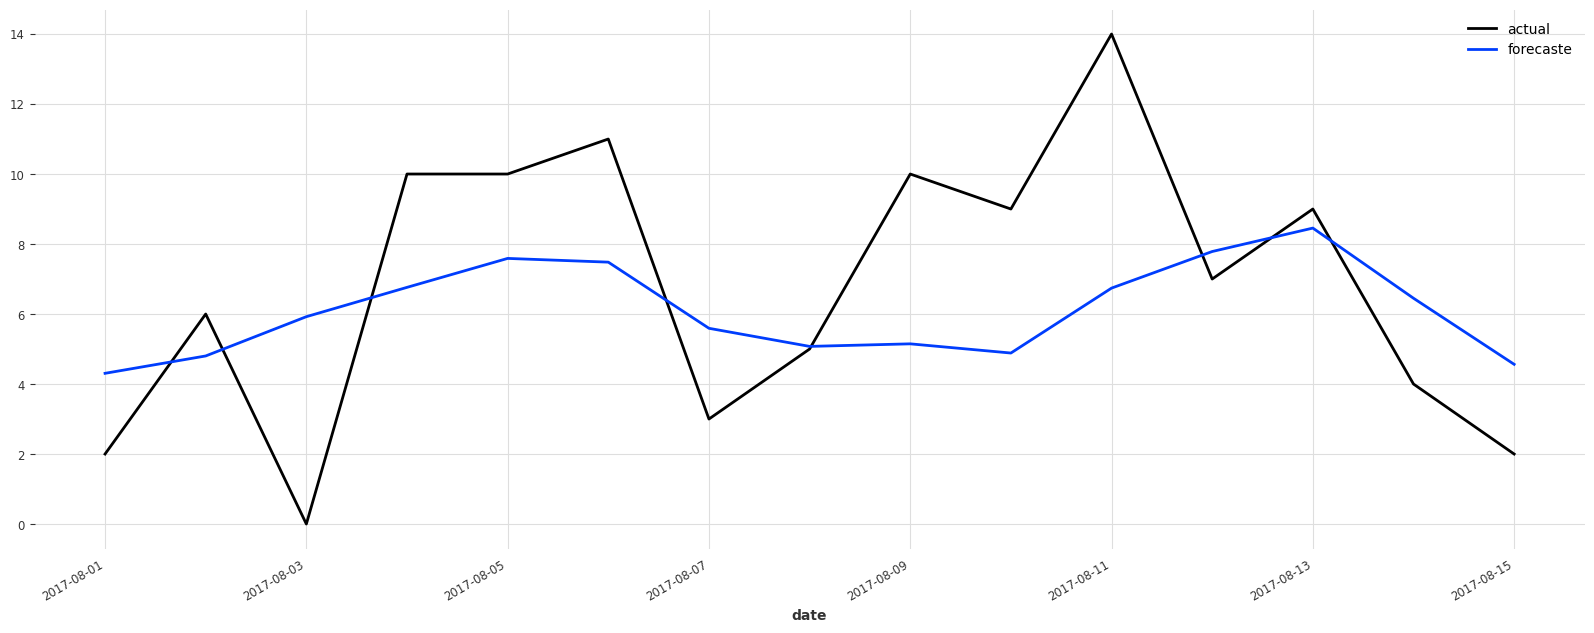

In [3]:
#Step 1. Load data and make it ready
train_data = pd.read_csv("./Data/train.csv", parse_dates = ['date'],  index_col='id')
test_data = pd.read_csv("./Data/test.csv", parse_dates = ['date'],  index_col='id')
oil_data = pd.read_csv("./Data/oil.csv", parse_dates= ["date"])
holiday_data = pd.read_csv("./Data/holidays_events.csv", parse_dates= ["date"])
stores_data = pd.read_csv("./Data/stores.csv")
trans_data = pd.read_csv("./Data/transactions.csv", parse_dates= ['date'])

## set basic variables
store_nbr = 2
family = "AUTOMOTIVE"
split_time = pd.Timestamp("2017-07-31")

## load the series
train_data = train_data[(train_data['store_nbr']==store_nbr) & (train_data['family']==family)]
test_data = test_data[(test_data['store_nbr']==store_nbr) & (test_data['family']==family)]
series = TimeSeries.from_dataframe(train_data, 
                                   time_col = 'date',  
                                   value_cols= ["sales" ],
                                   freq='D', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0)

series = series.astype(np.float64)

## train_test split
train_series, val_series = series.split_after(split_time)

## set train parameter
forecast_horizen = len(val_series)
lags_past_covariate = list(range(-1*forecast_horizen, -1*forecast_horizen-10, -1))

#Step 2. Transform train series

def sale_transformer(x):
    return np.log(x+100)

def sale_inverse_transformer(x):
    return np.exp(x)-100

log_transformer = InvertibleMapper(fn = sale_transformer, inverse_fn = sale_inverse_transformer, verbose=False, name="Log-Transform")   
sales_scaler = Scaler()
sales_pipeline = Pipeline([log_transformer, sales_scaler])

train_series_transformed = sales_pipeline.fit_transform(train_series)

#Step3. create past covariates

## create transaction series

trans_data_store = trans_data[(trans_data["store_nbr"]==store_nbr)& (trans_data["date"]< split_time + timedelta(days=1))]
transaction_ts_store = TimeSeries.from_dataframe(
    df =trans_data_store,
    time_col= "date",
    value_cols= "transactions",
    fill_missing_dates= True,
    fillna_value= 0,
    freq= 'D'
    )


if transaction_ts_store.start_time() > pd.Timestamp('20130101'):
    delta = (transaction_ts_store.start_time() - pd.Timestamp('20130101')).days
    constant_series = constant_timeseries(length=delta, value= 0, start= train_series.start_time())
    transaction_ts_store = constant_series.append(transaction_ts_store)

## tranform transaction series
trans_scaler_transformation = Scaler()

trans_train, trans_val = transaction_ts_store.split_after(split_time)
trans_train_transfrom = trans_scaler_transformation.fit_transform(trans_train)

## apply MA on the main train series and add the new series as past covariates
ma7 = MovingAverageFilter(window =7)
ma14 = MovingAverageFilter(window =14)
ma5 = MovingAverageFilter(window = 5)

series_ma5 = ma5.filter(train_series_transformed)
series_ma7 = ma7.filter(train_series_transformed)
series_ma14 = ma14.filter(train_series_transformed)


## define past covariates
past_covs = series_ma7.stack(series_ma14).stack(series_ma5).stack(trans_train_transfrom)

#Step4. Add future covariates

## step 4.1. create time-based future covariate

full_time_period = pd.date_range(start=train_data['date'].min(), end=test_data['date'].max(), freq='D')

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
#onthstart = datetime_attribute_timeseries(time_index = full_time_period, attribute="is_month_start")
#monthend = datetime_attribute_timeseries(time_index = full_time_period, attribute="is_month_end")
weekend = TimeSeries.from_times_and_values(
    times=weekday.time_index,
    values=np.where((weekday.values() == 5) | (weekday.values() == 6), 1, 0),
    columns=["weekend"]
)
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps).stack(weekend)#.stack(monthstart).stack(monthend)
time_cov = time_cov.astype(np.float32)

## Transform time_based future covariats
time_cov_scaler = Scaler()

time_cov_transformed = time_cov_scaler.fit_transform(time_cov)

## step 4.2. Add oil data as future cocariate
oil_data.fillna(method = "backfill", inplace = True)
oil_ts = TimeSeries.from_dataframe(
    df =oil_data,
    time_col= "date",
    value_cols= "dcoilwtico",
    fill_missing_dates= True,
    freq= 'D'
    )
oil_ts = oil_ts.astype(np.float64)
## Transform oil data

oil_filler = MissingValuesFiller()
oil_scaler = Scaler()
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil_ts)

## step 4.3 Add onpromotion as future covariate
train_data = train_data[(train_data['store_nbr']==store_nbr) & (train_data['family']==family)]
test_data = test_data[(test_data['store_nbr']==store_nbr) & (test_data['family']==family)]

train_promotion_ts = TimeSeries.from_dataframe(train_data, 
                                   time_col = 'date',  
                                   value_cols= ["onpromotion"],
                                   freq='D', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0)

test_promotion_ts = TimeSeries.from_dataframe(test_data, 
                                   time_col = 'date',  
                                   value_cols= ["onpromotion"],
                                   freq='D', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0)


onpromotion_ts = train_promotion_ts.append(test_promotion_ts)
# Transform onpromotion data
onpromotion_scaler = Scaler()
onpromotion_transformed = onpromotion_scaler.fit_transform(onpromotion_ts)

## Moving average on onpromition
onpromotion_ma7 = ma7.filter(onpromotion_transformed)
onpromotion_ma14 = ma14.filter(onpromotion_transformed)

## step 4.4. Add holidays as future covariates
holiday_data = holiday_data.drop_duplicates(subset = ['date'])
holiday_data['navidad'] = np.where(holiday_data.description.str.contains("Navidad"), 1, 0)
holiday_data['cantonizacion'] = np.where(holiday_data.description.str.contains("Cantonizacion"), 1,0)
holiday_data['fundacion'] = np.where(holiday_data.description.str.contains("Fundacion"),1,0)
holiday_data['independencia'] = np.where(holiday_data.description.str.contains("Independencia"),1,0)
holiday_data['provincializacion'] = np.where(holiday_data.description.str.contains("Provincializacion"),1,0)

holiday_ts = TimeSeries.from_dataframe(holiday_data, 
                                   time_col = 'date',  
                                   value_cols= ["navidad",'cantonizacion','fundacion','independencia' ,'provincializacion'],
                                   freq='D', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0)


_, holiday_ts = holiday_ts.split_before(series.start_time())
holiday_ts, _ = holiday_ts.split_after(test_data['date'].max())

## step 4.5 stacking all future covariates
future_covs = time_cov_transformed.stack(oil_transformed).stack(onpromotion_transformed).stack(onpromotion_ma7).stack(onpromotion_ma14).stack(holiday_ts)

#Final Step. train model and make prediction

lgbm = LightGBMModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [7, 14], output_chunk_length= 2 )
lgbm.fit(train_series_transformed , past_covariates= past_covs, future_covariates= future_covs )
y_hat = lgbm.predict(n = len(val_series), series= train_series_transformed, past_covariates= past_covs, future_covariates= future_covs)
y_hat_inverse = sales_pipeline.inverse_transform(y_hat)
y_hat_values =  y_hat_inverse.values()
y_hat_values[y_hat_values<0] = 0
y_hat_modified = TimeSeries.from_times_and_values(times = val_series.time_index, values= y_hat_values)

print(rmsle(val_series, y_hat_modified ))
print(mae(val_series, y_hat_modified ))


plt.figure(figsize = (20,7))

val_series.plot(label="actual")
y_hat_modified.plot(label="forecaste")

# Train on multiple series

## Step 1. Load data and make it ready

In [4]:

train_data = pd.read_csv("./Data/train.csv", parse_dates = ['date'],  index_col='id')
test_data = pd.read_csv("./Data/test.csv", parse_dates = ['date'],  index_col='id')
oil_data = pd.read_csv("./Data/oil.csv", parse_dates= ["date"])
holiday_data = pd.read_csv("./Data/holidays_events.csv", parse_dates= ["date"])
stores_data = pd.read_csv("./Data/stores.csv")
trans_data = pd.read_csv("./Data/transactions.csv", parse_dates= ['date'])

## set basic variables and merge main series
train_merged = pd.merge(train_data, stores_data, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
train_merged = train_merged.astype({"store_nbr":"category", "family":"category", "city":"category","state":"category", "type":"category", "cluster":'str'})

family_list =  list(train_data.groupby(['family'])['sales'].mean().sort_values(ascending=False).index)
#store_list = stores_data['store_nbr'].unique()
split_time = pd.Timestamp("2017-07-15")

# test_merged = pd.merge(test_data, stores_data, on = 'store_nbr')
# test_merged = test_merged.sort_values(["store_nbr","family","date"])
# test_merged = test_merged.astype({"store_nbr":'str', "family":'str', "city":'str',"state":'str', "type":'str', "cluster":'str'})


## All dictionaries we are going to create with key as family:train_dict, val_dict, sales_pipeline_dict, transformed_series_dict, 
train_dict = {}
val_dict = {}

sales_pipeline_dict ={}
train_series_transformed_dict = {}

past_covs_dict = {}
trans_list = []


future_covs_dict = {}
onpromotion_dict = {}
## Create multiple series within a list, saved in train and validation dictionary with family as key:


for family in family_list:
    train_dict[family] = []
    val_dict[family] = []
    tmp_df= train_merged[(train_merged['family']==family)]
    series_list = TimeSeries.from_group_dataframe(tmp_df, 
                                   time_col = 'date',  
                                   value_cols= ["sales" ],
                                   group_cols=["store_nbr","family"], 
                                   static_cols=["city","state","type","cluster"],
                                   freq='D', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0
                                   )
    for series in series_list:
        series = series.astype(np.float32)
        train_series, val_series = series.split_after(split_time)
        train_dict[family].append(train_series)
        val_dict[family].append(val_series)


store_list = []
for series in train_dict[family_list[0]]:
    store_list.append(series.static_covariates["store_nbr"].iloc[0])


## set train parameter
forecast_horizen = len(val_dict[family_list[0]][0])
lags_past_covariate = list(range(-1*forecast_horizen, -1*forecast_horizen-10, -1))

## Step 2. Transform train series

In [5]:

def sale_transformer(x):
    return np.log(x+100)

def sale_inverse_transformer(x):
    return np.exp(x)-100


sales_pipeline_dict ={}
train_series_transformed_dict = {}

for family in family_list:
    log_transformer = InvertibleMapper(fn = sale_transformer, inverse_fn = sale_inverse_transformer,)   
    sales_scaler = Scaler()
    static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = OneHotEncoder(), )
    sales_pipeline = Pipeline([log_transformer, sales_scaler, static_cov_transformer])
    sales_pipeline_dict[family] = sales_pipeline
    train_series_transformed_dict[family] = sales_pipeline_dict[family].fit_transform(train_dict[family])

## Step 3. Create past covariates


In [6]:
trans_list = []
## create transaction series
for stor_nbr in store_list:
    trans_data_store = trans_data[(trans_data["store_nbr"]==store_nbr)& (trans_data["date"]< split_time + timedelta(days=1))]
    transaction_ts_store = TimeSeries.from_dataframe(
        df =trans_data_store,
        time_col= "date",
        value_cols= "transactions",
        fill_missing_dates= True,
        fillna_value= 0,
        freq= 'D'
            )


    if transaction_ts_store.start_time() > pd.Timestamp('20130101'):
        delta = (transaction_ts_store.start_time() - pd.Timestamp('20130101')).days
        constant_series = constant_timeseries(length=delta, value= 0, start= train_data['date'].min())
        transaction_ts_store = constant_series.append(transaction_ts_store)

    ## tranform transaction series
    trans_scaler_transformation = Scaler()

    trans_train, trans_val = transaction_ts_store.split_after(split_time)
    trans_train_transfrom = trans_scaler_transformation.fit_transform(trans_train)
    trans_list.append(trans_train_transfrom)


## apply MA on the main train series and add the new series as past covariates

for family in family_list:
    past_covs_dict[family] = []
    for ind, series in enumerate(train_series_transformed_dict[family]):
        ma7 = MovingAverageFilter(window =7)
        ma14 = MovingAverageFilter(window =14)
        ma5 = MovingAverageFilter(window = 5)
        series_without_static_cov = TimeSeries.from_series(series.pd_series())
        series_ma5 = ma5.filter(series_without_static_cov)
        series_ma7 = ma7.filter(series_without_static_cov)
        series_ma14 = ma14.filter(series_without_static_cov)
        past_cov_tmp = series_ma7.stack(series_ma14).stack(series_ma5).stack(trans_list[ind])
        past_covs_dict[family].append(past_cov_tmp)

## Step 4. Add future covariates


In [7]:

## step 4.1. create time-based future covariate

full_time_period = pd.date_range(start=train_data['date'].min(), end=test_data['date'].max(), freq='D')

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
#onthstart = datetime_attribute_timeseries(time_index = full_time_period, attribute="is_month_start")
#monthend = datetime_attribute_timeseries(time_index = full_time_period, attribute="is_month_end")
weekend = TimeSeries.from_times_and_values(
    times=weekday.time_index,
    values=np.where((weekday.values() == 5) | (weekday.values() == 6), 1, 0),
    columns=["weekend"]
)
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps).stack(weekend)#.stack(monthstart).stack(monthend)
time_cov = time_cov.astype(np.float32)

## Transform time_based future covariats
time_cov_scaler = Scaler()

time_cov_transformed = time_cov_scaler.fit_transform(time_cov)

## step 4.2. Add oil data as future cocariate
oil_data.fillna(method = "backfill", inplace = True)
oil_ts = TimeSeries.from_dataframe(
    df =oil_data,
    time_col= "date",
    value_cols= "dcoilwtico",
    fill_missing_dates= True,
    freq= 'D'
    )
oil_ts = oil_ts.astype(np.float64)
## Transform oil data

oil_filler = MissingValuesFiller()
oil_scaler = Scaler()
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil_ts)

## step 4.3 Add onpromotion as future covariate
onpromotion_dict_raw= {}
for family in tqdm(family_list, desc = 'Creating onpromotion series'):
    onpromotion_dict[family] = []
    onpromotion_dict_raw[family] = []
    for store_nbr in store_list:
        train_tmp = train_data[(train_data['store_nbr']==int(store_nbr)) & (train_data['family']==family)]
        test_tmp = test_data[(test_data['store_nbr']==int(store_nbr)) & (test_data['family']==family)]


        train_promotion_ts = TimeSeries.from_dataframe(train_tmp, 
                                        time_col = 'date',  
                                        value_cols= ["onpromotion"],
                                        freq='D', 
                                        fill_missing_dates= True, 
                                        fillna_value= 0)

        test_promotion_ts = TimeSeries.from_dataframe(test_tmp, 
                                        time_col = 'date',  
                                        value_cols= ["onpromotion"],
                                        freq='D', 
                                        fill_missing_dates= True, 
                                        fillna_value= 0)

        
        onpromotion_ts = train_promotion_ts.append(test_promotion_ts)
        # Transform onpromotion data
        onpromotion_scaler = Scaler()
        onpromotion_transformed = onpromotion_scaler.fit_transform(onpromotion_ts)

        ## Moving average on onpromition
        ma7_promotion = MovingAverageFilter(window =7)
        ma14_promotion = MovingAverageFilter(window =14)
        onpromotion_ma7 = ma7_promotion.filter(onpromotion_transformed)
        onnpromotion_ma14 = ma14_promotion.filter(onpromotion_transformed)
        onpromotion_stacks_series = onpromotion_transformed.stack(onpromotion_ma7).stack(onpromotion_ma14)

        onpromotion_dict[family].append(onpromotion_stacks_series)
        onpromotion_dict_raw[family].append(onpromotion_ts)

## step 4.4. Add holidays as future covariates
holiday_data = holiday_data.drop_duplicates(subset = ['date'])
holiday_data['navidad'] = np.where(holiday_data.description.str.contains("Navidad"), 1, 0)
holiday_data['cantonizacion'] = np.where(holiday_data.description.str.contains("Cantonizacion"), 1,0)
holiday_data['fundacion'] = np.where(holiday_data.description.str.contains("Fundacion"),1,0)
holiday_data['independencia'] = np.where(holiday_data.description.str.contains("Independencia"),1,0)
holiday_data['provincializacion'] = np.where(holiday_data.description.str.contains("Provincializacion"),1,0)

holiday_ts = TimeSeries.from_dataframe(holiday_data, 
                                   time_col = 'date',  
                                   value_cols= ["navidad",'cantonizacion','fundacion','independencia' ,'provincializacion'],
                                   freq='D', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0)


_, holiday_ts = holiday_ts.split_before(series.start_time())
holiday_ts, _ = holiday_ts.split_after(test_data['date'].max())

## step 4.5 stacking all future covariates
for family in tqdm(family_list, desc = 'Creating future covariants series'):
    future_covs_dict[family] = []
    for i in range(len(store_list)):
        tmp = time_cov_transformed.stack(oil_transformed).stack(onpromotion_dict[family][i]).stack(holiday_ts)
        future_covs_dict[family].append(tmp)





Creating future covariants series: 100%|██████████| 33/33 [00:06<00:00,  4.75it/s]


In [8]:
onpromotion_ts

<TimeSeries (DataArray) (date: 1704, component: 1, sample: 1)>
array([[[0.]],

       [[0.]],

       [[0.]],

       ...,

       [[0.]],

       [[0.]],

       [[0.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-31
  * component  (component) object 'onpromotion'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Final Step. Train model and make prediction


### LightGBM

In [13]:
performance=[]
for family in family_list:
    

    train_series_transformed_dict[family]
    lgbm = LightGBMModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [7, 14], output_chunk_length= 2, verbose=-1 )
    lgbm.fit(train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat = lgbm.predict(n = forecast_horizen, series= train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat_inverse = sales_pipeline_dict[family].inverse_transform(y_hat)
    print(family, " "*(50-len(family)), round(rmsle(val_dict[family], y_hat_inverse, inter_reduction=np.mean),3))
    performance.append(round(rmsle(val_dict[family], y_hat_inverse, inter_reduction=np.mean),3))

final_sentence = "Mean of RMSLE through all families of products"
print("="*60 ,"\n",final_sentence, " "*(50-len(final_sentence)), round(sum(performance)/len(performance),3))


GROCERY I                                           0.165
BEVERAGES                                           0.217
PRODUCE                                             0.152
CLEANING                                            0.28
DAIRY                                               0.164
BREAD/BAKERY                                        0.181
POULTRY                                             0.213
MEATS                                               0.195
PERSONAL CARE                                       0.214
DELI                                                0.185
HOME CARE                                           0.228
EGGS                                                0.273
FROZEN FOODS                                        0.282
PREPARED FOODS                                      0.281
LIQUOR,WINE,BEER                                    0.483
SEAFOOD                                             0.488
GROCERY II                                          0.617
HOME AND KITCHE

#### Considering zero-leading time series independently

<AxesSubplot: xlabel='date'>

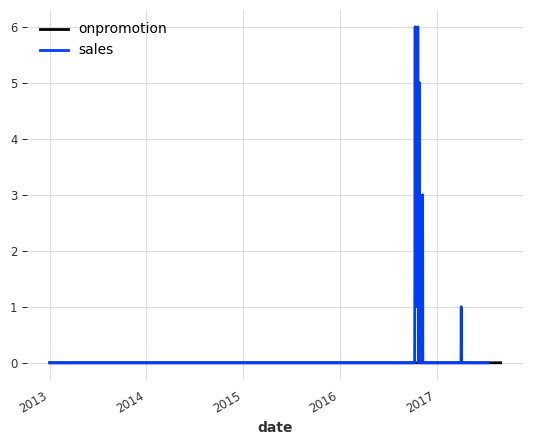

In [28]:
series_sample = train_dict['BOOKS'][5]
promotion_sample = onpromotion_dict_raw['BOOKS'][5]

promotion_sample.plot(label ="onpromotion")
series_sample.plot(label = "sales")

In [22]:
for ind, series in enumerate(train_dict['BOOKS']):
    if all(series[-60:]<=0):
        print(ind)

1
4
5
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
25
27
28
29
30
31
32
33
34
35
38
39
41
42
51
52
53


In [33]:
performance=[]
for family in family_list:
    

    train_series_transformed_dict[family]
    lgbm = LightGBMModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [7, 14], output_chunk_length= 2, verbose=-1 )
    lgbm.fit(train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat = lgbm.predict(n = forecast_horizen, series= train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat_inverse = sales_pipeline_dict[family].inverse_transform(y_hat)
    for ind, series in enumerate(train_dict[family]):
        if all(series[-60:]<= 0):
            y_hat_inverse[ind] = constant_timeseries(start=val_dict[family][ind].start_time(), end = val_dict[family][ind].end_time(), value =0)
    
    print(family, " "*(50-len(family)), round(rmsle(val_dict[family], y_hat_inverse, inter_reduction=np.mean),3))
    performance.append(round(rmsle(val_dict[family], y_hat_inverse, inter_reduction=np.mean),3))

final_sentence = "Mean of RMSLE through all families of products"
print("="*60 ,"\n",final_sentence, " "*(50-len(final_sentence)), round(sum(performance)/len(performance),3))


GROCERY I                                           0.165
BEVERAGES                                           0.217
PRODUCE                                             0.152
CLEANING                                            0.28
DAIRY                                               0.164
BREAD/BAKERY                                        0.181
POULTRY                                             0.213
MEATS                                               0.195
PERSONAL CARE                                       0.214
DELI                                                0.185
HOME CARE                                           0.228
EGGS                                                0.273
FROZEN FOODS                                        0.282
PREPARED FOODS                                      0.281
LIQUOR,WINE,BEER                                    0.483
SEAFOOD                                             0.488
GROCERY II                                          0.617
HOME AND KITCHE

It seems considering the zero leading series independenly can improve the accuracy of the model.

### XGBoost

In [34]:
performance=[]
for family in family_list:
    

    train_series_transformed_dict[family]
    xgb = XGBModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [7, 14], output_chunk_length= 2,)
    xgb.fit(train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat = xgb.predict(n = forecast_horizen, series= train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat_inverse = sales_pipeline_dict[family].inverse_transform(y_hat)
    y_hat_modified = []
    for ts in y_hat_inverse:
        ts_values =  ts.values()
        ts_values[ts_values<0] = 0
        ts_modified = TimeSeries.from_times_and_values(times = ts.time_index, values= ts_values)
        y_hat_modified.append(ts_modified)
        
    for ind, series in enumerate(train_dict[family]):
        if all(series[-60:]<= 0):
            y_hat_modified[ind] = constant_timeseries(start=val_dict[family][ind].start_time(), end = val_dict[family][ind].end_time(), value =0)

    print(family, " "*(50-len(family)), round(rmsle(val_dict[family], y_hat_modified, inter_reduction=np.mean),3))
    performance.append(round(rmsle(val_dict[family], y_hat_modified, inter_reduction=np.mean),3))

final_sentence = "Mean of RMSLE through all families of products"
print("="*60 ,"\n",final_sentence, " "*(50-len(final_sentence)), round(sum(performance)/len(performance),3))



GROCERY I                                           0.162
BEVERAGES                                           0.232
PRODUCE                                             0.171
CLEANING                                            0.285
DAIRY                                               0.161
BREAD/BAKERY                                        0.186
POULTRY                                             0.21
MEATS                                               0.194
PERSONAL CARE                                       0.22
DELI                                                0.188
HOME CARE                                           0.273
EGGS                                                0.272
FROZEN FOODS                                        0.287
PREPARED FOODS                                      0.281
LIQUOR,WINE,BEER                                    0.578
SEAFOOD                                             0.513
GROCERY II                                          0.684
HOME AND KITCHEN

### BlockRNNModel

In [10]:
from darts import TimeSeries

# Convert your input data to Double type since PyTorch expects tensors to have a data type of Double but your input data contains Float values.
for family in family_list:
    for ind, series in enumerate(train_series_transformed_dict[family]):
        train_series_transformed_dict[family][ind] = series.astype(float)  # Convert to float first
        train_series_transformed_dict[family][ind] = train_series_transformed_dict[family][ind].astype('double')  # Convert to Double

# Rest of your code...

performance=[]
for family in family_list:
    

    #train_series_transformed_dict[family]
    block_rnn = BlockRNNModel(
    model="LSTM",
    input_chunk_length=7,
    output_chunk_length=31,
    n_epochs=10,
    random_state=0,
    )
    block_rnn.fit(train_series_transformed_dict[family] , past_covariates= past_covs_dict[family],)
    y_hat = block_rnn.predict(n = forecast_horizen, series= train_series_transformed_dict[family] , past_covariates= past_covs_dict[family])
    y_hat_inverse = sales_pipeline_dict[family].inverse_transform(y_hat)
    y_hat_modified = []
    for ts in y_hat_inverse:
        ts_values =  ts.values()
        ts_values[ts_values<0] = 0
        ts_modified = TimeSeries.from_times_and_values(times = ts.time_index, values= ts_values)
        y_hat_modified.append(ts_modified)
        
    for ind, series in enumerate(train_dict[family]):
        if all(series[-60:]<= 0):
            y_hat_modified[ind] = constant_timeseries(start=val_dict[family][ind].start_time(), end = val_dict[family][ind].end_time(), value =0)

    print(family, " "*(50-len(family)), round(rmsle(val_dict[family], y_hat_modified, inter_reduction=np.mean),3))
    performance.append(round(rmsle(val_dict[family], y_hat_modified, inter_reduction=np.mean),3))

final_sentence = "Mean of RMSLE through all families of products"
print("="*60 ,"\n",final_sentence, " "*(50-len(final_sentence)), round(sum(performance)/len(performance),3))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | fc            | Sequential       | 806   
---------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GROCERY I                                           0.218


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | fc            | Sequential       | 806   
---------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

BEVERAGES                                           0.258


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | fc            | Sequential       | 806   
---------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\solmaz\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

PRODUCE                                             0.286


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | fc            | Sequential       | 806   
---------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

### Create an ensemble model using LightGBM and XGBoost

In [9]:
performance=[]
for family in family_list:

    xgb = XGBModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [7, 14], output_chunk_length= 2,)
    xgb.fit(train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat = xgb.predict(n = forecast_horizen, series= train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat_inverse = sales_pipeline_dict[family].inverse_transform(y_hat)
    y_hat_modified_xgb = []
    for ts in y_hat_inverse:
        ts_values =  ts.values()
        ts_values[ts_values<0] = 0
        ts_modified = TimeSeries.from_times_and_values(times = ts.time_index, values= ts_values)
        y_hat_modified_xgb.append(ts_modified)
        
    for ind, series in enumerate(train_dict[family]):
        if all(series[-60:]<= 0):
            y_hat_modified_xgb[ind] = constant_timeseries(start=val_dict[family][ind].start_time(), end = val_dict[family][ind].end_time(), value =0)


    lgbm = LightGBMModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [7, 14], output_chunk_length= 2, verbose=-1 )
    lgbm.fit(train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat = lgbm.predict(n = forecast_horizen, series= train_series_transformed_dict[family] , past_covariates= past_covs_dict[family], future_covariates= future_covs_dict[family])
    y_hat_inverse_lgbm = sales_pipeline_dict[family].inverse_transform(y_hat)
    for ind, series in enumerate(train_dict[family]):
        if all(series[-60:]<= 0):
            y_hat_inverse_lgbm[ind] = constant_timeseries(start=val_dict[family][ind].start_time(), end = val_dict[family][ind].end_time(), value =0)

    model_selected = {}

    score_xgb = rmsle(val_dict[family], y_hat_modified_xgb, inter_reduction=np.mean)
    score_lgbm = rmsle(val_dict[family], y_hat_inverse_lgbm, inter_reduction=np.mean)

    #y_hat_final = None


    if score_lgbm<=score_xgb:
        y_hat_final = y_hat_inverse_lgbm
        model_selected[family]= 'lgbm'
    else:
        y_hat_final = y_hat_modified_xgb
        model_selected[family] = 'xgb'


    rmsle_final = round(rmsle(val_dict[family], y_hat_final, inter_reduction=np.mean),3)


    print(family, " "*(50-len(family)),rmsle_final ," "*30 ,f"Model:{model_selected[family]}")
    performance.append(rmsle_final)

final_sentence = "Mean of RMSLE through all families of products"
print("="*60 ,"\n",final_sentence, " "*(50-len(final_sentence)), round(sum(performance)/len(performance),3))

GROCERY I                                           0.171                                Model:xgb
BEVERAGES                                           0.217                                Model:lgbm
PRODUCE                                             0.151                                Model:lgbm
CLEANING                                            0.284                                Model:lgbm
DAIRY                                               0.15                                Model:xgb
BREAD/BAKERY                                        0.178                                Model:lgbm
POULTRY                                             0.211                                Model:lgbm
MEATS                                               0.193                                Model:xgb
PERSONAL CARE                                       0.219                                Model:lgbm
DELI                                                0.18                                Model:xgb
HOME C